In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

In [2]:
dataset = xr.open_dataset("tco100_omimls_oct2004_to_dec2024_1by1.nc")
dataset

<xarray.Dataset> Size: 63MB
Dimensions:  (months: 243, y_elements: 180, x_elements: 360)
Dimensions without coordinates: months, y_elements, x_elements
Data variables:
    TropoO3  (months, y_elements, x_elements) float32 63MB ...
Attributes:
    Title:    OMI/MLS Ground-to-100hPa Column Ozone for TOARII, etc.

OMI/MLS Ground-to-300hPa Column Ozone for TOARII *y_elements: latitude, x_elements: longitude, period: October 2004 - December 2024

So now it is time for some data cleaning, there should not be negative values in the data

In [3]:
ozone = dataset["TropoO3"]
cleaned_ozone_dataset = ozone.where(ozone >= 0)
dataset["TropoO3"] = cleaned_ozone_dataset

In [4]:
ozone = cleaned_ozone_dataset 

# adding month from attributes to coordinate
month = ozone.attrs['Month'].split(',')
first_month = month[0]                              # October 2004
last_month = month[-1].replace(' ', '')             # December 2024

start_date = datetime.strptime(first_month, "%b%Y")
end_date = datetime.strptime(last_month, "%b%Y")

time_coords = pd.date_range(start=start_date, end=end_date, freq='MS')

In [5]:
# renaming and assigning/removing dimensions
ozone = ozone.assign_coords(time=('months', time_coords))
ozone = ozone.rename({"time": "yearmonth",'y_elements': 'latitude', 'x_elements': 'longitude'})
ozone = ozone.swap_dims({'months': 'yearmonth'})

Subsetting necessary months. This is January 2005 - December 2024 ONLY

In [6]:
ozone_subsetted = ozone.sel(yearmonth=slice("2005-01-01", "2024-12-01")) ####

In [7]:
# grouping by calendar month
monthly_mean = ozone_subsetted.groupby('yearmonth.month').mean('yearmonth')
monthly_stdev = ozone.groupby('yearmonth.month').std('yearmonth') # group it with means

In [8]:
monthly_mean = monthly_mean.assign_attrs(_FillValue="-999",name="Tropospheric Ozone Mean, Ground to 100 hPa")
monthly_stdev = monthly_stdev.assign_attrs(_FillValue="-999",name="Tropospheric Ozone STDEV, Ground to 100 hPa")

del monthly_mean.attrs['Month']
del monthly_stdev.attrs['Month']

#monthly_mean

In [9]:
# adding lat/lon from attributes to coordinates
lat_coords = ozone_subsetted.attrs['latitude'].split(',')
first_lat = float(lat_coords[0])
last_lat = float(lat_coords[-1])

lon_coords = ozone_subsetted.attrs['longitude'].split(',')
first_lon = float(lon_coords[0])
last_lon = float(lon_coords[-1])

lon_coords = np.arange(first_lon, 180.5, 1)
lat_coords = np.arange(first_lat,90.5, 1)

monthly_mean = monthly_mean.assign_coords(
    longitude=('longitude', lon_coords),
    latitude=('latitude', lat_coords)
)

monthly_stdev = monthly_stdev.assign_coords(
    longitude=('longitude', lon_coords),
    latitude=('latitude', lat_coords)
)

In [19]:
monthly_mean.min()

<xarray.DataArray 'TropoO3' ()> Size: 8B
array(9.35975075)

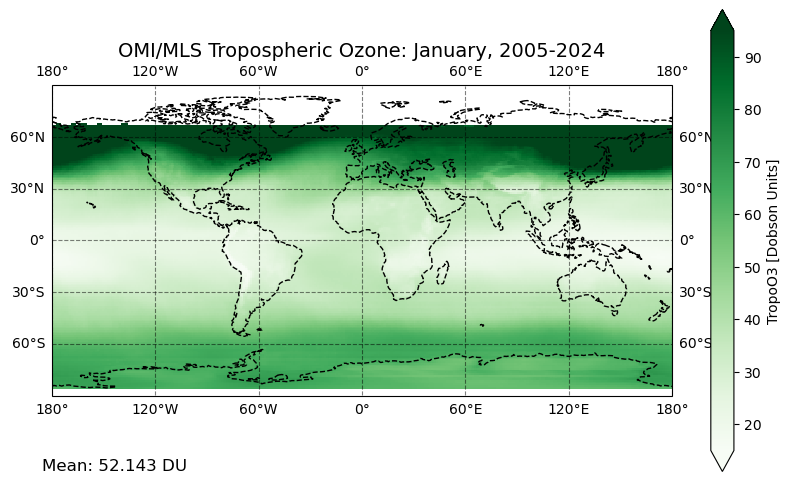

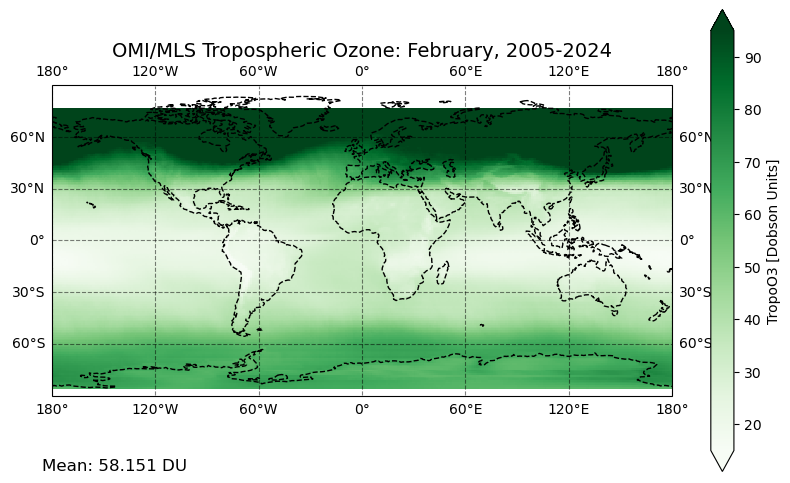

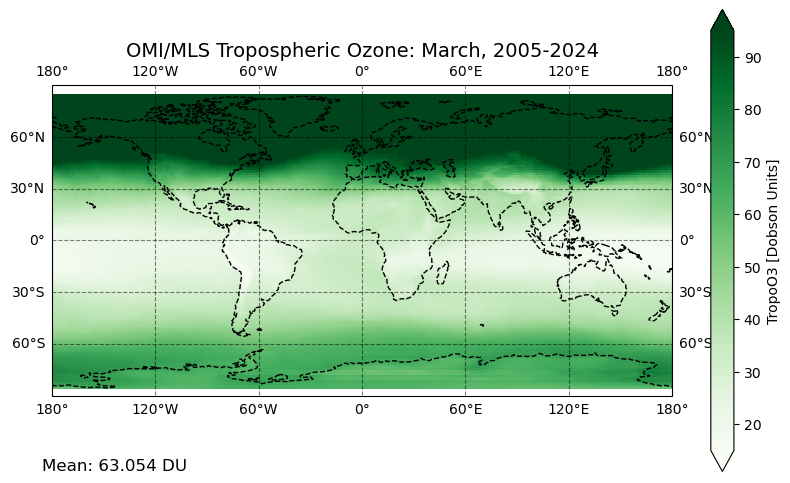

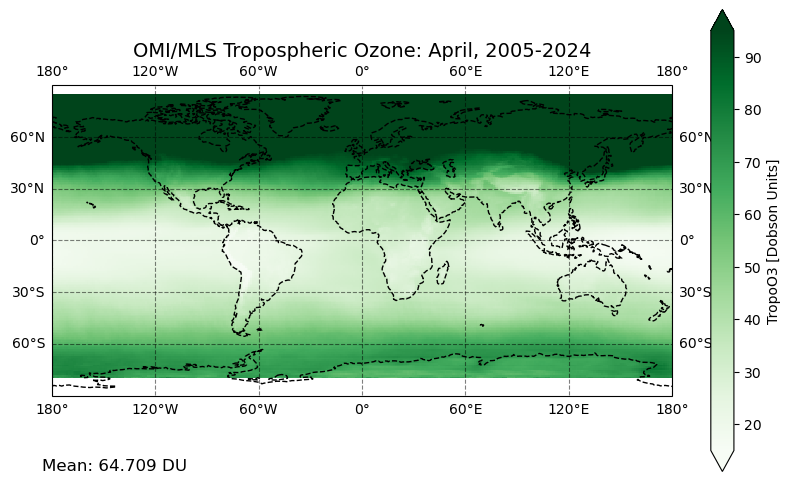

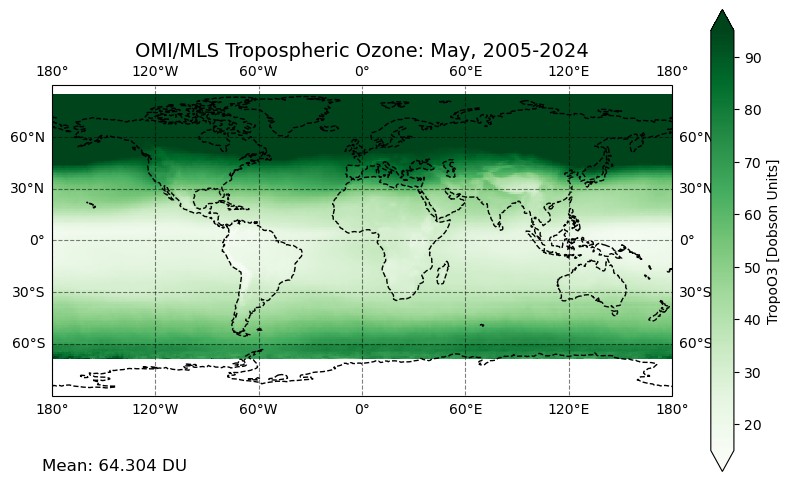

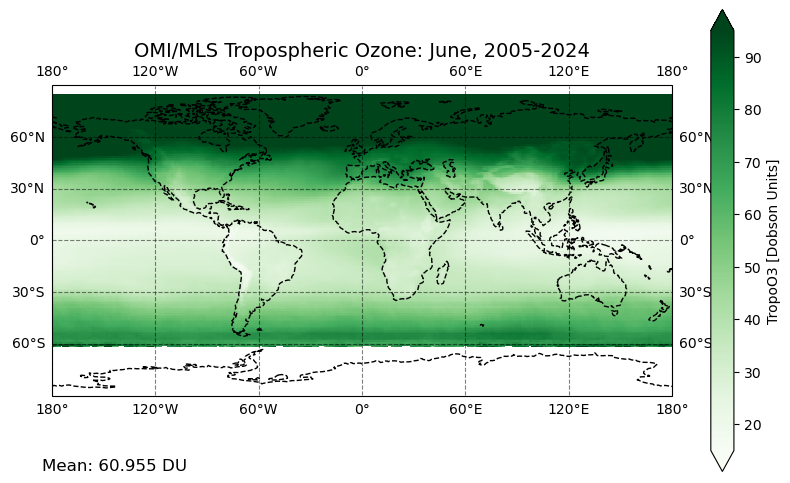

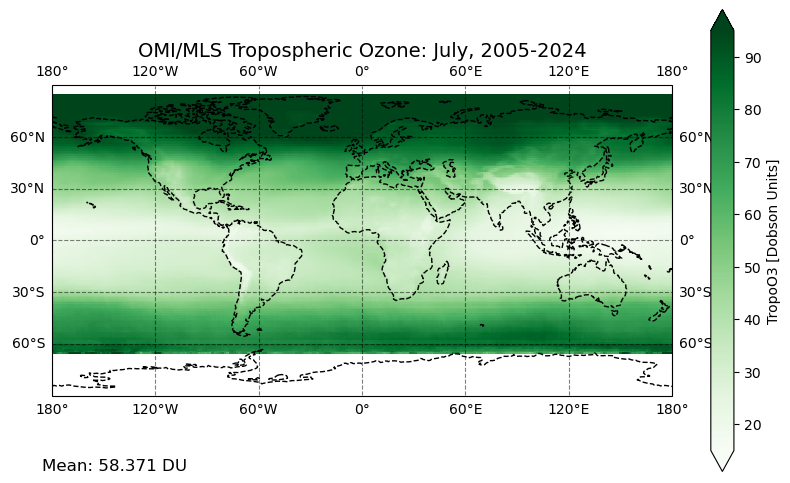

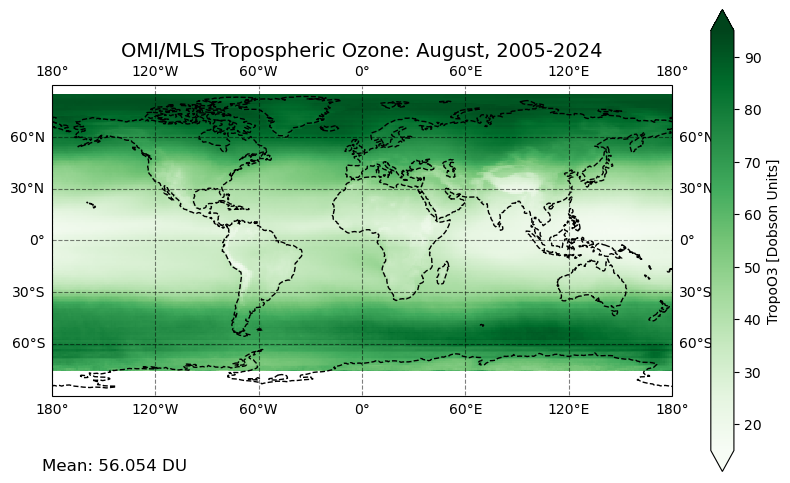

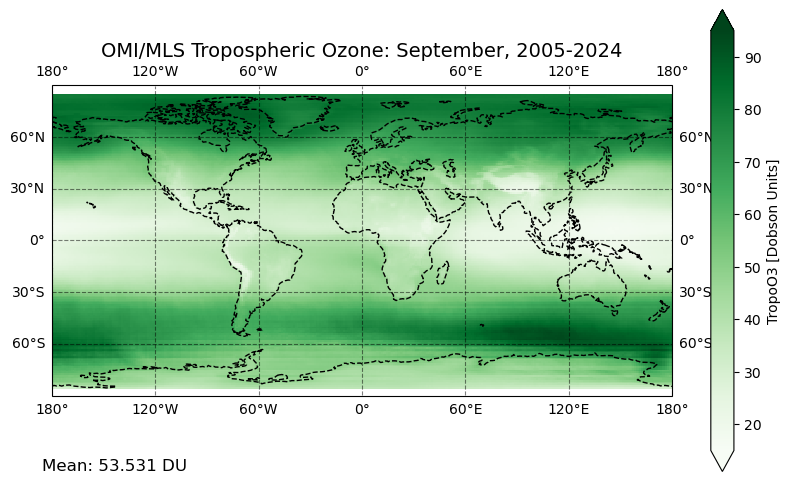

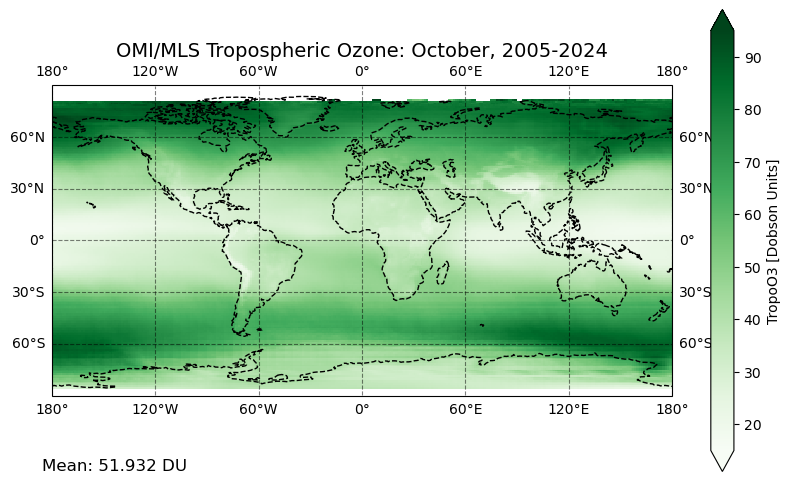

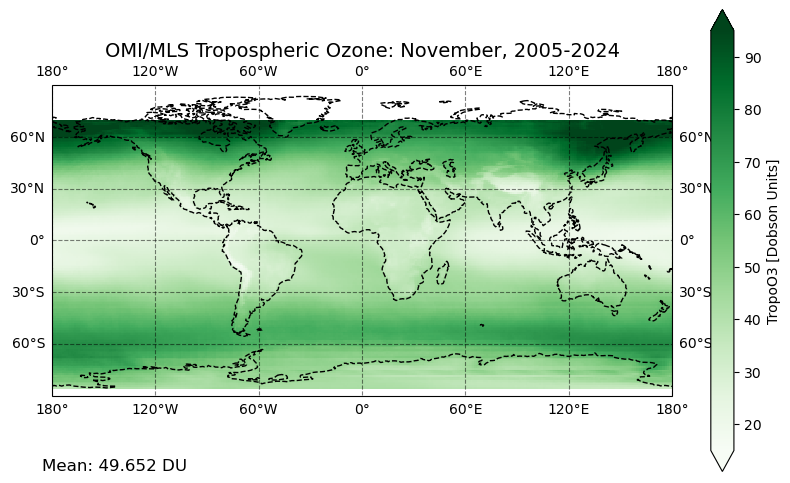

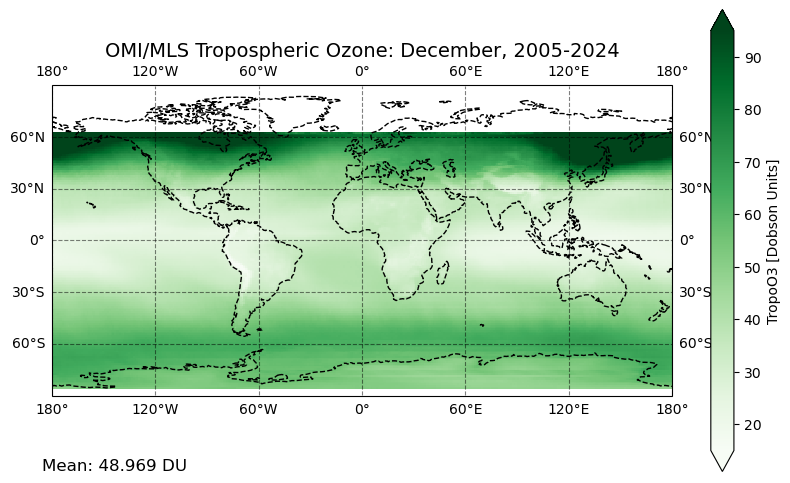

In [21]:
# plot the monthly means

month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'] # for cycling through figures to create a gif

i=0

for month in month_list:
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    monthly_mean[i].plot(ax=ax,transform=ccrs.PlateCarree(central_longitude=0), 
                         x='longitude', y='latitude', vmin=15, vmax=95, extend='both', cmap='Greens')
    ax.add_feature(cfeature.COASTLINE, linestyle='--')
    ax.set_global()

    # adding gridlines
    ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')

    ax.set_title('OMI/MLS Tropospheric Ozone: ' + str(month) + ', 2005-2024', fontsize=14)
    formatted_mean = f"{monthly_mean[i].mean().data:.3f}"

    ax.text(0.10, -0.25, 'Mean: ' + str(formatted_mean) + ' DU', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=12)

    #plt.savefig("figures/Monthly_Mean_TropoO3-" + str(alphabet[i]))
    plt.show()
    i+=1

Now save as NETCDF4 files

In [11]:
monthly_mean.fillna(-999)

<xarray.DataArray 'TropoO3' (month: 12, latitude: 180, longitude: 360)> Size: 3MB
array([[[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
...
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]]], dtype=float32)
Coordinates:
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    units:       Dobson Units
    name:        Tropospheric Ozone Mean, Ground to 100 hPa
    latitude:    -89.5, -88.5, ..., 89.5
    longitude:   -179.5, -178.5, ..., 179.5
    _FillValue:  -999

In [12]:
#monthly_mean.to_netcdf(path="/glade/u/home/mvoncyga/SOARS_2025/OMIMLS_100hpa_monthly_mean_2005_2024.nc",format="NETCDF4")

In [13]:
monthly_stdev.fillna(-999)

<xarray.DataArray 'TropoO3' (month: 12, latitude: 180, longitude: 360)> Size: 3MB
array([[[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
...
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]]], dtype=float32)
Coordinates:
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    units:       Dobson Units
    name:        Tropospheric Ozone STDEV, Ground to 100 hPa
    latitude:    -89.5, -88.5, ..., 89.5
    longitude:   -179.5, -178.5, ..., 179.5
    _FillValue:  -999

In [14]:
#monthly_stdev.to_netcdf(path="/glade/u/home/mvoncyga/SOARS_2025/OMIMLS_300hpa_monthly_stdev_2005_2024.nc",format="NETCDF4")